In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA, KernelPCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, learning_curve, validation_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

In [214]:
plt.rc('font', family='Malgun Gothic')

In [205]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    #print(xx1)
    #print(xx2)
    #print(np.array([xx1.ravel(), xx2.ravel()]).T)
    
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

In [206]:
app = pd.read_csv('application_record.csv')
credit = pd.read_csv('credit_record.csv')
credit['STATUS'].value_counts()

C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: STATUS, dtype: int64

In [207]:
# credit.drop('MONTHS_BALANCE', axis=1, inplace=True)
# credit['STATUS'].replace({'C': 0, 'X' : 0}, inplace=True)
# credit['STATUS'] = credit['STATUS'].astype('int')
# credit['STATUS'] = credit['STATUS'].apply(lambda x: 1 if x >= 1 else 0)
# credit_gb = credit.groupby('ID').max()
# credit_gb
credit.drop('MONTHS_BALANCE', axis=1, inplace=True)
credit['STATUS'] = credit['STATUS'].map({'C':0,'X':0,'0':1,'1':2,'2':3,'3':4,'4':5,'5':6})
# credit['STATUS'] = credit['STATUS'].map({'C':0, 'X':0, '0':0, '1':0, '2':1, '3':1, '4':1, '5':1})
credit_gb = credit.groupby('ID').sum()['STATUS']
credit_gb = credit_gb.apply(lambda x: 1 if x >= 15 else 0)
credit_gb.value_counts()

0    37719
1     8266
Name: STATUS, dtype: int64

In [208]:
df = pd.merge(app, credit_gb, on='ID', how='inner')
df = df.set_index('ID')

In [209]:

df.loc[:, 'NAME_INCOME_TYPE'] = df['NAME_INCOME_TYPE'].map({'Working':0, 'Commercial associate':1, 'Pensioner':2, 'State servant':3, 'Student':4})
df.loc[:, 'NAME_EDUCATION_TYPE'] = df['NAME_EDUCATION_TYPE'].map({'Secondary / secondary special':0, 'Higher education':1, 'Incomplete higher':2,
                                 'Lower secondary':3, 'Academic degree':4})
df.loc[:, 'NAME_HOUSING_TYPE'] = df['NAME_HOUSING_TYPE'].map({'House / apartment':0, 'With parents':1, 'Municipal apartment':2, 
                              'Rented apartment':3, 'Office apartment':4, 'Co-op apartment':5})
df.loc[:, 'NAME_FAMILY_STATUS'] = df['NAME_FAMILY_STATUS'].map({'Married':0, 'Single / not married':1, 
                                                                'Civil marriage':2, 'Separated':3, 'Widow':4})


C:\Users\PC\AppData\Local\Temp\ipykernel_5772\3559060617.py:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'NAME_INCOME_TYPE'] = df['NAME_INCOME_TYPE'].map({'Working':0, 'Commercial associate':1, 'Pensioner':2, 'State servant':3, 'Student':4})
C:\Users\PC\AppData\Local\Temp\ipykernel_5772\3559060617.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'NAME_EDUCATION_TYPE'] = df['NAME_EDUCATION_TYPE'].map({'Secondary / secondary special':0, 'Higher education':1, 'Incomplete higher':2,
C:\Users\PC\AppData\Local\Temp\ipyk

In [210]:
df['DAYS_BIRTH'] = abs(df['DAYS_BIRTH'] // 365)
df['DAYS_EMPLOYED'] = abs(df['DAYS_EMPLOYED'].apply(lambda x: 0 if x == 365243 else x) // 365)
df['CODE_GENDER'] = df['CODE_GENDER'].map({'M':0, 'F':1})
df['FLAG_OWN_CAR'] = df['FLAG_OWN_CAR'].map({'N':0, 'Y':1})
df['FLAG_OWN_REALTY'] = df['FLAG_OWN_REALTY'].map({'N':0, 'Y':1})

df.drop('OCCUPATION_TYPE', axis=1, inplace=True)

In [211]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# train/valid/test 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

# 그래프

In [28]:
# def corr(x, y, **kwargs):
#     # 상관계수를 계산합니다.
#     coef = np.corrcoef(x, y)[0][1]
#     # 상관계수를 문자열로 바꿉니다.
#     label = r'$\rho$ = ' + str(round(coef, 2))
#     # 상관계수를 그래프 상단에 표시합니다.
#     ax = plt.gca()
#     ax.annotate(label, xy = (0.2, 0.95), size = 20, xycoords = ax.transAxes)

# # pairplot을 그립니다.
# g = sns.PairGrid(X_train)

# # 대각선 아래쪽에는 산점도를 그립니다.
# g.map_lower(sns.scatterplot, color = 'blue')

# # 대각선 위쪽에는 상관계수를 표시합니다.
# g.map_upper(corr)

# # 대각선에는 히스토그램을 그립니다.
# g.map_diag(sns.histplot, color = 'blue')

# plt.show()

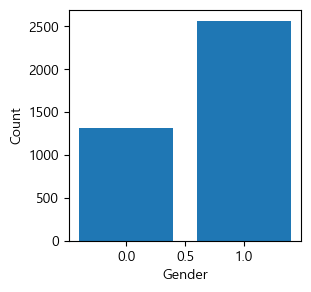

In [215]:
# y_train이 1인 행만 선택
mask = y_train == 1
selected_X_train = X_train[mask]

# 카테고리별로 개수 세기
gender_counts = selected_X_train['CODE_GENDER'].value_counts()

# 막대그래프 그리기
plt.figure(figsize=(3, 3))
plt.bar(gender_counts.index, gender_counts.values)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

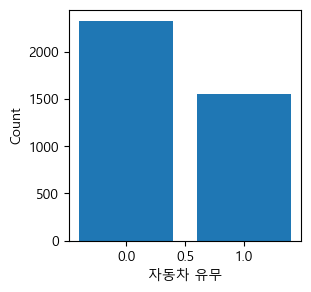

In [216]:
# y_train이 1인 행만 선택
mask = y_train == 1
selected_X_train = X_train[mask]

# 카테고리별로 개수 세기
gender_counts = selected_X_train['FLAG_OWN_CAR'].value_counts()

# 막대그래프 그리기
plt.figure(figsize=(3, 3))
plt.bar(gender_counts.index, gender_counts.values)
plt.xlabel('자동차 유무')
plt.ylabel('Count')
plt.show()

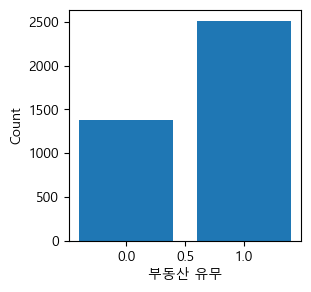

In [218]:
# y_train이 1인 행만 선택
mask = y_train == 1
selected_X_train = X_train[mask]

# 카테고리별로 개수 세기
gender_counts = selected_X_train['FLAG_OWN_REALTY'].value_counts()

# 막대그래프 그리기
plt.figure(figsize=(3, 3))
plt.bar(gender_counts.index, gender_counts.values)
plt.xlabel('부동산 유무')
plt.ylabel('Count')
plt.show()

In [220]:
# # y_train이 1인 행만 선택
# mask = y_train == 1
# selected_X_train = X_train[mask]

# # 카테고리별로 개수 세기
# gender_counts = selected_X_train['NAME_INCOME_TYPE'].value_counts()

# # 막대그래프 그리기
# plt.figure(figsize=(8, 3))
# plt.bar(gender_counts.index, gender_counts.values)
# plt.xlabel('Income Type')
# plt.ylabel('Bad rate [%]')
# plt.show()

In [ ]:
# plt.figure(figsize=(10,6))
# sns.countplot(x='NAME_INCOME_TYPE', hue='STATUS', data=df)
# plt.title('직업별 STATUS 분포')
# plt.show()

In [ ]:
# plt.figure(figsize=(10,6))
# sns.countplot(x='NAME_EDUCATION_TYPE', hue='STATUS', data=df)
# plt.title('학력별 STATUS 분포')
# plt.show()

In [ ]:
# plt.figure(figsize=(10,6))
# sns.countplot(x='NAME_FAMILY_STATUS', hue='STATUS', data=df)
# plt.title('결혼 유무별 STATUS 분포')
# plt.show()

In [ ]:
# plt.figure(figsize=(10,6))
# sns.countplot(x='NAME_HOUSING_TYPE', hue='STATUS', data=df)
# plt.title('집 형태별 STATUS 분포')
# plt.show()

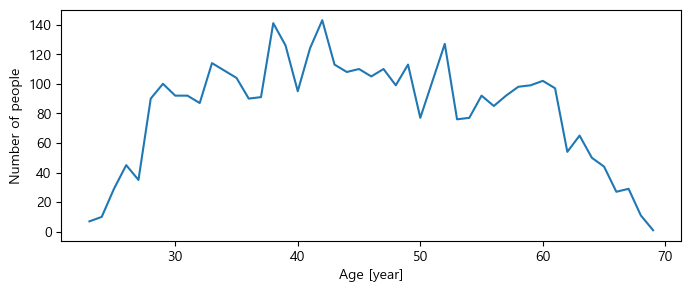

In [221]:
# byage = df.groupby('DAYS_BIRTH')['STATUS'].mean()

# plt.figure(figsize=(8, 3))
# plt.plot(byage)
# plt.xlabel('Age [year]')
# plt.ylabel('Bad rate [%]')
# plt.show()

# 카테고리별로 개수 세기
birth_counts = selected_X_train['DAYS_BIRTH'].value_counts().sort_index()

# 나이로 변환 (-1을 곱한 후, 365.25로 나누기)
age_counts = birth_counts.index

# 막대그래프 그리기
plt.figure(figsize=(8, 3))
plt.plot(age_counts, birth_counts.values)
plt.xlabel('Age [year]')
plt.ylabel('Number of people')
plt.show()


In [ ]:
# bins = [0, 5, 10, 15, 20, 25, 30, 35, 40]
# labels = [0, 5, 10, 15, 20, 25, 30, 35 ]
# df['DAYS_EMPLOYED'] = pd.cut(df['DAYS_EMPLOYED'], bins=bins, labels=labels, right=False)

# plt.figure(figsize=(10,6))
# sns.countplot(x='DAYS_EMPLOYED', hue='STATUS', data=df)
# plt.title('근속년수별 STATUS 분포')
# plt.show()

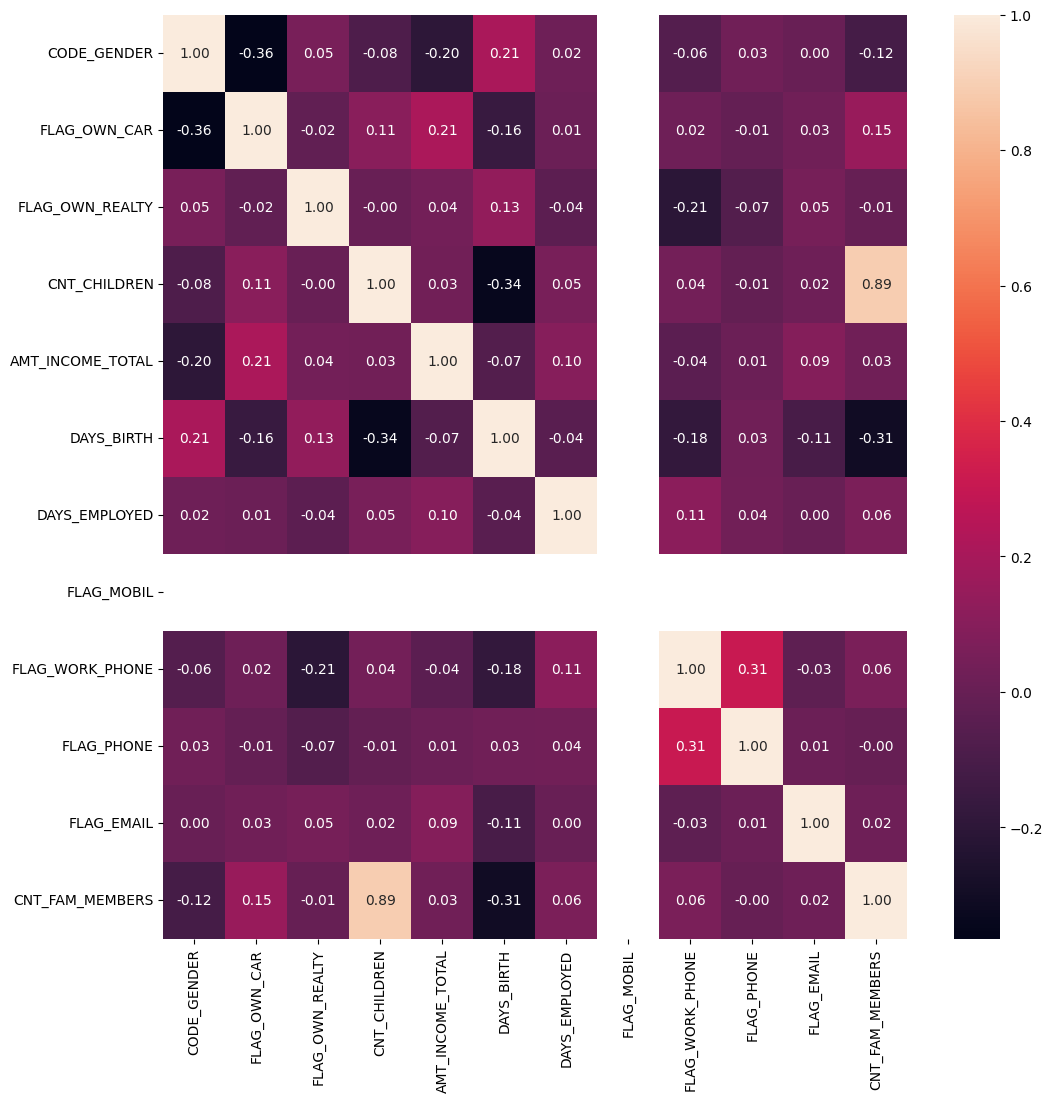

In [41]:
# plt.figure(figsize=(12,12))
# sns.heatmap(X_train.corr(numeric_only=True), annot=True, fmt='.2f')
# plt.show()

# 인코딩

In [222]:
X_train = X_train[['CODE_GENDER', 'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'DAYS_BIRTH', 'DAYS_EMPLOYED']]
X_test = X_test[['CODE_GENDER', 'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'DAYS_BIRTH', 'DAYS_EMPLOYED']]
X_val = X_val[['CODE_GENDER', 'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'DAYS_BIRTH', 'DAYS_EMPLOYED']]
X_train

,CODE_GENDER,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,DAYS_BIRTH,DAYS_EMPLOYED
ID,,,,,,,
5053627,1,81000.0,2,0,0,60,0
5085746,1,202500.0,0,0,0,39,1
5148948,1,90000.0,0,0,0,49,16
5125977,0,148500.0,0,1,3,34,4
5105385,0,180000.0,2,0,2,65,0
...,...,...,...,...,...,...,...
5142120,0,180000.0,0,0,0,37,1
5067092,0,202500.0,0,1,0,41,6
5062697,1,157500.0,0,0,0,40,11


In [112]:
from sklearn.preprocessing import LabelEncoder

# X_train = pd.get_dummies(X_train, drop_first=True)
# X_test = pd.get_dummies(X_test, drop_first=True)
# X_val = pd.get_dummies(X_val, drop_first=True)

# encoder = LabelEncoder()

# for column in ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']:
#     X_train[column] = encoder.fit_transform(X_train[column])
# for column in ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']:
#     X_test[column] = encoder.fit_transform(X_test[column])
# for column in ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']:
#     X_val[column] = encoder.fit_transform(X_val[column])

# # 소수 클래스 오버스케일링
# sampler = SMOTE(sampling_strategy=0.5)
# X_train, y_train = sampler.fit_resample(X_train, y_train)
# X_test, y_test = sampler.fit_resample(X_test, y_test)
# X_val, y_val = sampler.fit_resample(X_val, y_val)

X_train


,CODE_GENDER,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow
ID,,,,,,,,,,,,,,,,
5053627,1,81000.0,60,0,1,0,0,0,0,0,0,1,1,0,0,0
5085746,1,202500.0,39,1,0,0,0,1,0,0,0,1,1,0,0,0
5148948,1,90000.0,49,16,0,0,0,1,0,0,0,1,1,0,0,0
5125977,0,148500.0,34,4,0,0,0,1,1,0,0,0,0,1,0,0
5105385,0,180000.0,65,0,1,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5142120,0,180000.0,37,1,0,0,0,1,0,0,0,1,1,0,0,0
5067092,0,202500.0,41,6,0,0,0,1,1,0,0,0,1,0,0,0
5062697,1,157500.0,40,11,0,0,0,1,0,0,0,1,1,0,0,0


In [93]:
# X_train.drop(['FLAG_PHONE', 'CNT_CHILDREN', 'NAME_HOUSING_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 
#               'FLAG_MOBIL', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'FLAG_WORK_PHONE'], axis=1, inplace=True)
# X_test.drop(['FLAG_PHONE', 'CNT_CHILDREN', 'NAME_HOUSING_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 
#               'FLAG_MOBIL', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'FLAG_WORK_PHONE'], axis=1, inplace=True)
# X_val.drop(['FLAG_PHONE', 'CNT_CHILDREN', 'NAME_HOUSING_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 
#               'FLAG_MOBIL', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'FLAG_WORK_PHONE'], axis=1, inplace=True)
# X_train

# 특성 선택

In [38]:
# from sklearn.ensemble import RandomForestClassifier

# # forest = RandomForestClassifier(criterion='gini', max_depth=4, n_estimators=25, random_state=1, n_jobs=-1)
# forest = RandomForestClassifier(n_estimators=100, random_state=1)
# forest.fit(X_train, y_train)

In [39]:
# ipt = forest.feature_importances_
# idxs = np.argsort(ipt)[::-1] # 역순

# plt.figure(figsize=(10,6))
# plt.bar(np.array(X_train.columns)[idxs], ipt[idxs]) # ipt[idxs 중요도
# plt.xticks(rotation=90)
# plt.show()

# 스케일링

In [223]:
X_train = X_train.copy()

std_scaler = StandardScaler()
std_columns = ['AMT_INCOME_TOTAL']
X_train[std_columns] = std_scaler.fit_transform(X_train[std_columns])
X_val[std_columns] = std_scaler.transform(X_val[std_columns])
X_test[std_columns] = std_scaler.transform(X_test[std_columns])


mM_scaler = MinMaxScaler()
mM_columns = ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS']
X_train[mM_columns] = mM_scaler.fit_transform(X_train[mM_columns])
X_val[mM_columns] = mM_scaler.transform(X_val[mM_columns])
X_test[mM_columns] = mM_scaler.transform(X_test[mM_columns])

X_train


,CODE_GENDER,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,DAYS_BIRTH,DAYS_EMPLOYED
ID,,,,,,,
5053627,1,-1.037472,0.5,0.00,0.00,0.808511,0.000000
5085746,1,0.148650,0.0,0.00,0.00,0.361702,0.022727
5148948,1,-0.949611,0.0,0.00,0.00,0.574468,0.363636
5125977,0,-0.378515,0.0,0.25,0.75,0.255319,0.090909
5105385,0,-0.071002,0.5,0.00,0.50,0.914894,0.000000
...,...,...,...,...,...,...,...
5142120,0,-0.071002,0.0,0.00,0.00,0.319149,0.022727
5067092,0,0.148650,0.0,0.25,0.00,0.404255,0.136364
5062697,1,-0.290654,0.0,0.00,0.00,0.382979,0.250000


# 모델 선택

In [224]:
high_score = 0
best_model = None

for c in range(-3, 3):
    lr = LogisticRegression(solver='liblinear', C=10**c, random_state=1)
    model = lr.fit(X_train, y_train)
    p_val = lr.predict(X_val)
    score = f1_score(y_val, p_val)
    if score > high_score:
        high_score = score
        best_model = model
        
for i in range(6,25):
    forest = RandomForestClassifier(criterion='gini', max_depth=i, n_estimators=300, random_state=1, n_jobs=-1)
    model = forest.fit(X_train, y_train)
    p_val = forest.predict(X_val)
    score = f1_score(y_val, p_val)
    if score > high_score:
        high_score = score
        best_model = model

print('Best F1-score:', high_score)
best_model

Best F1-score: 0.3070301291248207


RandomForestClassifier(max_depth=23, n_estimators=300, n_jobs=-1,
                       random_state=1)

# 차원 축소

In [201]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# lda = LDA(n_components=7)
# X_train_lda = lda.fit_transform(X_train, y_train)

# # lda instance reference is used here
# X_test_lda = lda.transform(X_test)

# plt.scatter(X_train_lda[y_train==0], np.zeros((np.sum(y_train==0),1)), color='red')
# plt.scatter(X_train_lda[y_train==1], np.zeros((np.sum(y_train==1),1)), color='blue')
# plt.show()


In [ ]:
# from sklearn.decomposition import KernelPCA, PCA

# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X_train_sc)

# plt.figure(figsize=(10,1))
# plt.scatter(X_pca[y_train==0,0], np.zeros_like(X_pca[y_train==0,0])) # np.zeros(X_pca[y==0,0].shape)
# plt.scatter(X_pca[y_train==1,0], np.zeros_like(X_pca[y_train==1,0]))
# plt.show()

In [86]:
# from sklearn.decomposition import KernelPCA

# # 먼저 훈련 데이터에 대해서 fit_transform을 수행합니다.
# pca = KernelPCA(n_components=7, kernel='rbf', gamma=30)
# X_train_kpca = pca.fit_transform(X_train)

# # 그 후, 테스트 데이터에 대해서는 transform만 수행합니다.
# X_test_kpca = pca.transform(X_test)

# # 그래프 그리기
# plt.figure(figsize=(10,1))
# plt.scatter(X_train_kpca[y_train==0,0], X_train_kpca[y_train==0,1]) 
# plt.scatter(X_train_kpca[y_train==1,0], X_train_kpca[y_train==1,1])
# plt.show()

# # 먼저 훈련 데이터에 대해서 fit_transform을 수행합니다.
# pca = KernelPCA(n_components=7, kernel='rbf', gamma=30)
# X_val_kpca = pca.fit_transform(X_val)

# # 그 후, 테스트 데이터에 대해서는 transform만 수행합니다.
# Xval_kpca = pca.transform(X_test)

# # 그래프 그리기
# plt.figure(figsize=(10,5))
# plt.scatter(X_val_kpca[y_val==0,0], X_val_kpca[y_val==0,1]) 
# plt.scatter(X_val_kpca[y_val==1,0], X_val_kpca[y_val==1,1])
# plt.show()


# 교차검증

In [116]:
from sklearn.model_selection import cross_val_score

# SVC(C=1, gamma=1, random_state=1)
# 순서대로
lr_pipe = make_pipeline(RandomForestClassifier(criterion='gini', max_depth=i, n_estimators=300, random_state=1, n_jobs=-1))
# lr_pipe.fit(X_train, y_train)
# lr_pipe.predict(X_test)
cvscore = cross_val_score(estimator=lr_pipe, X=X_train, y=y_train, cv=10, n_jobs=-1) # 10조각(kfold)
print('\n교차검증(CV) 정확도 : ', np.mean(cvscore))
for i, j in enumerate(cvscore):
    print(f'{i+1}번 : {j}')


교차검증(CV) 정확도 :  0.8309192352488107
1번 : 0.8299057412167952
2번 : 0.8243359040274207
3번 : 0.8349764252036005
4번 : 0.8392627518216889
5번 : 0.8371195885126447
6번 : 0.8242606086583798
7번 : 0.8298328332618946
8번 : 0.8251178739819974
9번 : 0.836262323189027
10번 : 0.8281183026146592


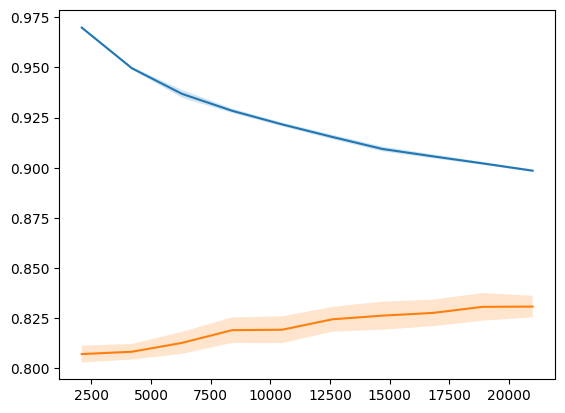

In [117]:
from sklearn.model_selection import learning_curve

sizes, train_score, val_score = learning_curve(estimator=lr_pipe, X=X_train, y=y_train, 
                                               train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=-1)

train_mean = np.mean(train_score, axis=1)
val_mean = np.mean(val_score, axis=1)
train_std = np.std(train_score, axis=1)
val_std = np.std(val_score, axis=1)

plt.figure()
plt.plot(sizes, train_mean)
plt.fill_between(sizes, train_mean+train_std, train_mean-train_std, alpha=0.2)

plt.plot(sizes, val_mean)
plt.fill_between(sizes, val_mean+val_std, val_mean-val_std, alpha=0.2)

plt.show()

# 모델 테스트

In [152]:
svc = SVC(C=0.01, gamma=15, random_state=1, kernel='rbf', probability=True)
svc.fit(X_train, y_train)

SVC(C=0.01, gamma=15, probability=True, random_state=1)

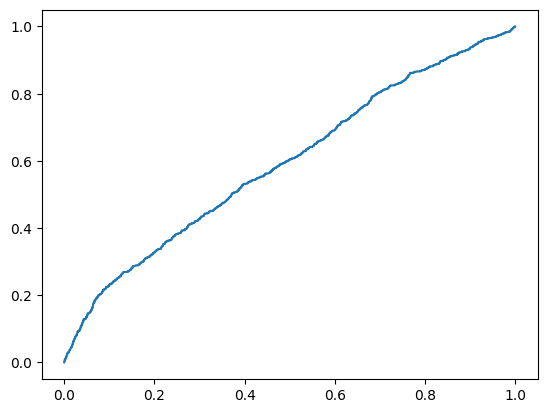

In [157]:
prob = svc.predict_proba(X_test)
fpr, tpr, thres = roc_curve(y_test, prob[:,1])
roc_auc_score(y_test, prob[:,1])
plt.figure()
plt.plot(fpr, tpr)
plt.show()

In [132]:
rnd_fore = RandomForestClassifier(criterion='gini', max_depth=i, n_estimators=300, random_state=1, n_jobs=-1)
rnd_fore.fit(X_train, y_train)

RandomForestClassifier(max_depth=9, n_estimators=300, n_jobs=-1, random_state=1)

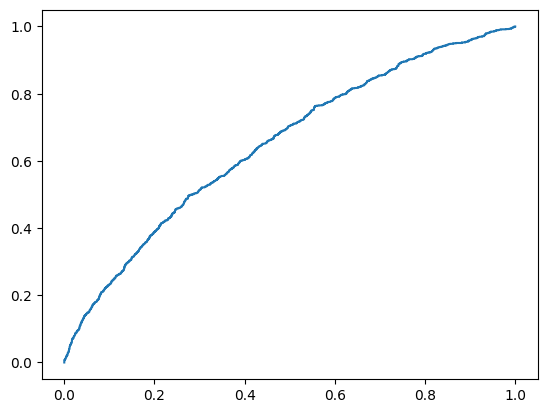

In [156]:
prob = rnd_fore.predict_proba(X_test)

fpr, tpr, thres = roc_curve(y_test, prob[:,1])
roc_auc_score(y_test, prob[:,1])
plt.figure()
plt.plot(fpr, tpr)
plt.show()

In [145]:
lr = LogisticRegression(solver='liblinear', C=0.1, random_state=1)
lr.fit(X_train, y_train)

LogisticRegression(C=0.1, random_state=1, solver='liblinear')

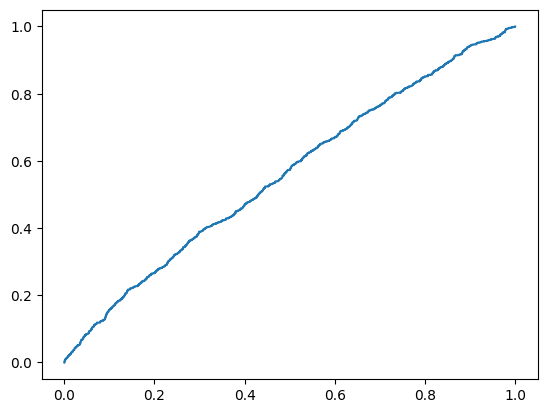

In [146]:
prob = lr.predict_proba(X_test)
prob

fpr, tpr, thres = roc_curve(y_test, prob[:,1])
roc_auc_score(y_test, prob[:,1])
roc_auc_score(y_test, prob[:,1])
plt.figure()
plt.plot(fpr, tpr)
plt.show()

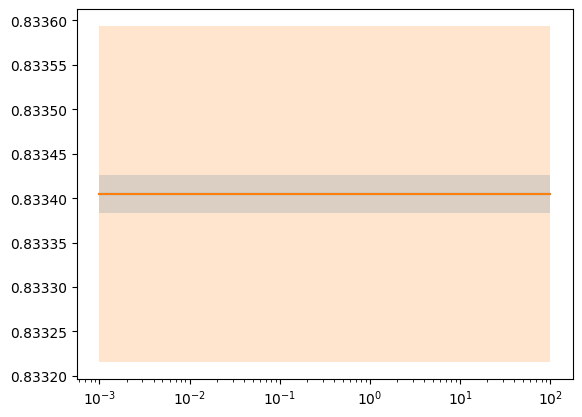

In [121]:
from sklearn.model_selection import validation_curve

# SVC(kernel='rbf', C=1, random_state=1, gamma=1)

C_range = np.logspace(-3, 2, 6)
lr_pipe = make_pipeline(
                        
                        LogisticRegression(solver='liblinear', C=10, random_state=1))

train_score, val_score = validation_curve(estimator=lr_pipe, X=X_train, y=y_train, 
                                        param_name='logisticregression__C', param_range=C_range, 
                                        cv=10, n_jobs=-1)

train_mean = np.mean(train_score, axis=1)
val_mean = np.mean(val_score, axis=1)
train_std = np.std(train_score, axis=1)
val_std = np.std(val_score, axis=1)

plt.figure()
plt.plot(C_range, train_mean)
plt.fill_between(C_range, train_mean+train_std, train_mean-train_std, alpha=0.2)

plt.plot(C_range, val_mean)
plt.fill_between(C_range, val_mean+val_std, val_mean-val_std, alpha=0.2)

plt.xscale('log')
plt.show()

In [122]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

svc_pipe = make_pipeline(SVC(random_state=1))
C_range = np.logspace(-4, 3, 8)
gamma_range = np.logspace(-4, 3, 8)
param_grid = [{'svc__C':C_range, 
               'svc__kernel':['linear']},
              {'svc__C':C_range, 
              'svc__gamma':gamma_range, 
              'svc__kernel':['rbf']}]

# 학습기만 생성됨
gs = GridSearchCV(estimator=svc_pipe, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1)

In [123]:
# 얘는 학습결과를 덮어써야 함.
gs = gs.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
gs.best_score_